# TrkQualTrain.ipynb

The notebook to train the TrkQual algorithm. Note that this runs on v6 EventNtuples. The general workflow is:
* take EventNtuple datasets and produce smaller trkqual_tree files,
* take data from the trkqual_tree files and train the TrkQual ML models, and
* save the model, plots, etc.

## Import Python Packages

In [1]:
import types
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import xgboost # not in pyana
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc

import tf2onnx
import onnx

import keras
print(f"Keras version: {keras.__version__}")

2025-09-24 11:52:23.691444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version: 2.15.0


## Class Definitions

Here we define two useful classes:
* ```Dataset```: will hold features, momentum resolutions, etc. for a given dataset
* ```MLModel```: will hold information about each ML model

In [2]:
class Dataset:
    """Define datasets for TrkQual training"""

    def __init__(self, name, dataset, trkqual_tree_dirname, is_training):
        self.name = name
        self.dataset = dataset
        self.filelist = "filelists/"+dataset+".list"
        self.trkqualtree = trkqual_tree_dirname + "/trkqual_tree_v2.0_"+name+".root"
        self.is_training = is_training
        self.predictions = { } # create an empty dictionary

    def add(self, features, reco_mom, mc_mom):
        self.features = features
        self.reco_mom = reco_mom
        self.mc_mom = mc_mom
        
        self.mom_res = self.reco_mom - self.mc_mom
        self.high_qual = high_quality(self.mom_res)
        self.low_qual = low_quality(self.mom_res)

    def add_predictions(self, model, predictions):
        self.predictions[model] = predictions

class MLModel:
    def __init__(self, model, name, training_version, fit_func, predict_func, save_func):
        self.model = model
        self.name = name
        self.training_version = training_version
        self.fit_func = types.MethodType(fit_func, self)
        self.predict_func = types.MethodType(predict_func, self)
        self.save_func = types.MethodType(save_func, self)

    def add_trkqual_cut(self, trkqual_cut):
        self.trkqual_cut = trkqual_cut

    def add_roc_curve(self, fpr, tpr, thresholds):
        self.fpr = fpr
        self.tpr = tpr
        self.thresholds = thresholds

## Common Definitions (datasets, features, and quality)

Here we define:
* where we will store the smaller TrkQual tree files,
* which datasets we want to train / validate on,
* which features to use, and
* the definitions of high quality and low quailty 

In [3]:
# Location of TrkQual trees
trkqual_tree_dirname = '/exp/mu2e/data/users/edmonds/TrkQualTraining'

# Datasets
training_dataset_name = "nts.mu2e.FlateMinusMix1BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root"
validation_dataset_name = "nts.mu2e.CeEndpointMix1BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root"
mock_dataset_name = "nts.mu2e.ensembleMDS2cMix1BBTriggered.MDC2020ba_best_v1_3_v06_06_00.root" # we can also look at its effect on the mock data

# Features
feature_names = ["nactive", "factive", "t0err", "fambig", "fitcon", "momerr", "fstraws"]
feature_branches = ["trk.nactive", "trk.factive", "trk_ent_pars.t0err", "trk.fambig", "trk.fitcon", "trk_ent.momerr", "trk.fstraws"]
n_features = len(feature_names)
def get_features(batch, mask): # this will receive a "batch" of tracks

    # these features are derived from other branches
    batch['trk.factive'] = batch['trk.nactive'] / batch['trk.nhits']
    batch['trk.fambig'] = batch['trk.nnullambig'] / batch['trk.nactive']
    batch['trk.fstraws'] = batch['trk.nmatactive'] / batch['trk.nactive']
    
    features = [ ]
    for name,branch in zip(feature_names, feature_branches):
        features.append((batch[branch][mask]).to_numpy())
    return features

# High quality and low quality definitions
def high_quality(mom_res):
    return (mom_res>-0.25) & (mom_res<0.25)

def low_quality(mom_res):
    return (mom_res>0.7)

In [4]:
# shouldn't need to edit this cell
is_training = True
is_not_training = False
training_dataset = Dataset("training", training_dataset_name, trkqual_tree_dirname, is_training)
validation_dataset = Dataset("validation", validation_dataset_name, trkqual_tree_dirname, is_not_training)
mock_dataset = Dataset("mock", mock_dataset_name, trkqual_tree_dirname, is_not_training)

datasets = [ training_dataset, validation_dataset, mock_dataset ]

## Model Definitions

Here we will define the models that we want to train. Currently, we train:
* a linear and quadratic discriminant, and
* an artificial neural network

In [5]:
# Linear Discriminant Analysis 1
lda1 = LinearDiscriminantAnalysis()
def save_unimplemented(ml_model):
    print(ml_model.name+ " does not have an implemented save function")
    
def lda1_fit(ml_model,x_train,y_train, x_test, y_test): # should take an MLModel, note x_test, y_test unused for LDA
    return ml_model.model.fit(x_train, y_train)

def lda1_prediction(ml_model, features):
    return ml_model.model.predict_proba(features)[:,1].ravel()

lda1_training_version = 1
lda1_ml = MLModel(lda1, "LDA1", lda1_training_version, lda1_fit, lda1_prediction, save_unimplemented)

In [6]:
# Quadratic Discriminant Analysis 1
qda1 = QuadraticDiscriminantAnalysis()
    
def qda1_fit(ml_model,x_train,y_train, x_test, y_test): # should take an MLModel, note x_test, y_test unused for LDA
    return ml_model.model.fit(x_train, y_train)

def qda1_prediction(ml_model, features):
    return ml_model.model.predict_proba(features)[:,1].ravel()

qda1_training_version = 1
qda1_ml = MLModel(qda1, "QDA1", qda1_training_version, qda1_fit, qda1_prediction, save_unimplemented)

In [7]:
# Artificial Neural Network 1

# Structure:
# - N, N-1 nodes in the hidden layers
# - sigmoid activation functions
ann1 = tf.keras.Sequential(name='sequential')
ann1.add(tf.keras.layers.Input(shape=(n_features,), batch_size=1, name='input'))
ann1.add(tf.keras.layers.Dense(n_features, activation='sigmoid', name='dense'))
ann1.add(tf.keras.layers.Dense(n_features, activation='sigmoid', name='dense_1'))
ann1.add(tf.keras.layers.Dense(n_features-1, activation='sigmoid', name='dense_2'))
ann1.add(tf.keras.layers.Dense(1, activation='sigmoid', name='dense_3'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # was 1e-3 (2e-2 is from TMVA)
ann1.compile(loss='binary_crossentropy',
                 metrics=['accuracy'],
                 optimizer=optimizer)
                 #run_eagerly=True)
ann1.summary()

def save_keras_ann_to_onnx(ml_model):
    tspecs = [tf.TensorSpec(i.shape, dtype=i.dtype, name=i.name) for i in ml_model.model.inputs]
    onnx_model, _ = tf2onnx.convert.from_keras(ml_model.model, input_signature=tspecs)
    onnx.save(onnx_model, f"model/TrkQual_{ml_model.name}_v{ml_model.training_version}.onnx")

def ann1_fit(ml_model, x_train, y_train, x_test, y_test):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    keras.utils.set_random_seed(340)
    history = ml_model.model.fit(x_train, y_train,
                                  epochs=500,
                                #steps_per_epoch=10,
                                  verbose=0,
                                  validation_data=(x_test, y_test),
                                  callbacks=[early_stop])
    return history

def ann1_prediction(ml_model, features):
    return ml_model.model.predict(features)[:,0]

ann1_training_version = 2
ann1_ml = MLModel(ann1, "ANN1", ann1_training_version, ann1_fit, ann1_prediction, save_keras_ann_to_onnx)
print("Done!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 7)                    56        
                                                                 
 dense_1 (Dense)             (1, 7)                    56        
                                                                 
 dense_2 (Dense)             (1, 6)                    48        
                                                                 
 dense_3 (Dense)             (1, 1)                    7         
                                                                 
Total params: 167 (668.00 Byte)
Trainable params: 167 (668.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Done!


In [8]:
# A new model can go in this cell (don't forget to add to the list of models_to_train in the next cell too!)


In [9]:
# Now put all the models in a list so we can train them all later
models_to_train = [ lda1_ml, qda1_ml, ann1_ml ]

## Create TrkQual trees

First we use RooUtil to create the TrkQual trees. The script is in scripts/TrkQualTree.C. You can look at it with ```!cat scripts/TrkQualTree.C```

In [10]:
for dataset in datasets:
    bash_script=f"""
    if [ -f {dataset.trkqualtree} ]; then 
        echo Training tree {dataset.trkqualtree} already exists
    else 
        echo Training tree {dataset.trkqualtree} does not exist. Making now...
        source /cvmfs/mu2e.opensciencegrid.org/setupmu2e-art.sh
        muse setup EventNtuple
        
        if [ -f {dataset.filelist} ]; then
           echo Filelist already exists
        else
            echo " Creating filelist..."
            setup mu2efiletools
            mu2eDatasetFileList {dataset.dataset} > {dataset.filelist}
        fi
        
        root -l -b -q scripts/TrkQualTree.C++\\(\\"{dataset.filelist}\\",\\"{dataset.trkqualtree}\\"\\)
    fi
    """
    # Execute the bash script
    get_ipython().run_cell_magic('bash', '', bash_script)

print("Done!")

Training tree /exp/mu2e/data/users/edmonds/TrkQualTraining/trkqual_tree_v2.0_training.root already exists
Training tree /exp/mu2e/data/users/edmonds/TrkQualTraining/trkqual_tree_v2.0_validation.root already exists
Training tree /exp/mu2e/data/users/edmonds/TrkQualTraining/trkqual_tree_v2.0_mock.root already exists
Done!


## Extract data for trainings

Now we go through each dataset and get the features and momentum resolutions

In [11]:
for dataset in datasets:

    # We will put the variables we want into numpy arrays
    trk_ent_mom=[] # reco momentum at tracker entrance
    trk_ent_mc_mom=[] # MC true momentum at tracker entrance

    # We will store the features in here. It is a 2D array
    all_features = [[]] * n_features

    trkqual_tree = uproot.open(dataset.trkqualtree+":trkqualtree")
    print(dataset.trkqualtree.split('/')[-1].strip('\n') + ": "+str(trkqual_tree.num_entries)+" entries")
    
    # Iterate through the entries in the file
    for batch, report in trkqual_tree.iterate(step_size="10 MB", report=True, library='ak'):
        # Make some aliases for new columns
        batch['trk_ent.mom'] = (batch['trk_ent.mom.fCoordinates.fX']**2 + batch['trk_ent.mom.fCoordinates.fY']**2 + batch['trk_ent.mom.fCoordinates.fZ']**2)**0.5
        batch['trk_ent_mc.mom'] = (batch['trk_ent_mc.mom.fCoordinates.fX']**2 + batch['trk_ent_mc.mom.fCoordinates.fY']**2 + batch['trk_ent_mc.mom.fCoordinates.fZ']**2)**0.5
    
    
        # A mask for selecting good tracks to tracks to train on
        # startCode 173 is for FlateMinus
        track_mask = (batch['trk.status']>0) & (batch['trk.goodfit']==1) & ~np.isnan(batch['trk_ent_pars.t0err'])
        if dataset.is_training:
            track_mask = (track_mask) & (batch['trk_sim.startCode']==173)
    
        # Here we keep on appending to the arrays
        trk_ent_mom = np.append(trk_ent_mom, (batch['trk_ent.mom'][track_mask]).to_numpy())
        trk_ent_mc_mom = np.append(trk_ent_mc_mom, (batch['trk_ent_mc.mom'][track_mask]).to_numpy())

        # Get the features using the definitions defined in get_features
        these_features = get_features(batch, track_mask)
        for i,f in enumerate(these_features):
            all_features[i] = np.concatenate((all_features[i], f))

    # Now we are done iterating through the TrkQual tree 
    # so organize our training features into the correct shape
    features=np.vstack(all_features).T
    # and add everything to the dataset for easier use later
    dataset.add(features, trk_ent_mom, trk_ent_mc_mom)

# Since this cell takes a while, we'll print to say that we're done
print("Done!")

trkqual_tree_v2.0_training.root: 452686 entries
trkqual_tree_v2.0_validation.root: 1218140 entries
trkqual_tree_v2.0_mock.root: 342289 entries
Done!


## Post data extraction checks

We will now check the momentum resolution and features of the training sample to make sure things look as expected

In [12]:
def plot_mom_res(dataset, n_mom_res_bins, min_mom_res, max_mom_res):
    fig, ax = plt.subplots(1, 1)
    counts, bins, patches = ax.hist(dataset.mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label=\
'all tracks')
    counts, bins, patches = ax.hist(dataset.mom_res[dataset.high_qual], bins=bins, log=True, histtype='step', label='high-quality tracks')
    counts, bins, patches = ax.hist(dataset.mom_res[dataset.low_qual], bins=bins, log=True, histtype='step', label='low-quality tracks')

    ax.legend()
    ax.margins(x=0)
    ax.grid(True)
    ax.set_title('.'.join(dataset.dataset.split('.')[2:4]))
    ax.set_xlabel("Momentum Resolution [MeV/c]")
    ax.set_ylabel("Number of Tracks")

    return fig, ax

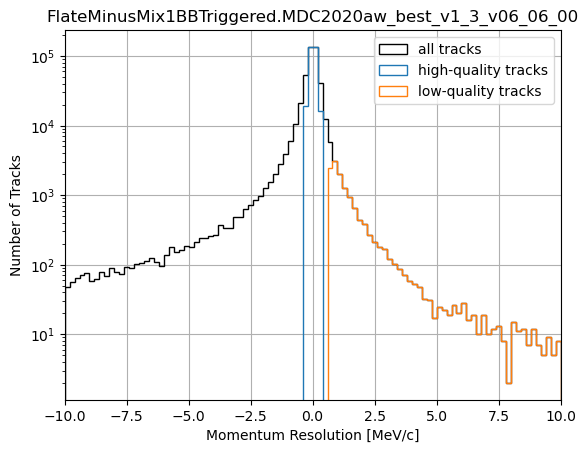

In [13]:
min_mom_res=-10
max_mom_res=10
n_mom_res_bins=100

training_dataset = datasets[0]
fig, ax = plot_mom_res(training_dataset, n_mom_res_bins, min_mom_res, max_mom_res)

In [14]:
def plot_features(dataset):
    fig, axs = plt.subplots(3, 3, figsize=(16,9))
    fig.subplots_adjust(hspace=.5)

    x_mins=[0, 0, 0, 0, 0, 0, 0]
    x_maxs=[100, 1, 3, 1, 1, 5, 5]
    log_ys=[False, True, True, True, True, True, True]
    #log_ys=[False, False, False, False, False, False, False]
    units=['[count]', '[fraction]', '[ns]', '[fraction]', '', '[MeV/c]', '[1/fraction]']
    density=True # note: density=True means each histogram is normalized to unit area
    fig.suptitle('.'.join(dataset.dataset.split('.')[2:4]))

    for i_var in range(0, n_features):
        bins, counts, patches = axs.flatten()[i_var].hist(dataset.features[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='all tracks', density=density)
        bins, counts, patches = axs.flatten()[i_var].hist(dataset.features[:,i_var][dataset.high_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='high-quality tracks', density=density)
        bins, counts, patches = axs.flatten()[i_var].hist(dataset.features[:,i_var][dataset.low_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='low-quality tracks', density=density)
        axs.flatten()[i_var].set_xlabel(feature_names[i_var]+" "+units[i_var])
        axs.flatten()[i_var].margins(0)
        axs.flatten()[i_var].legend()

    return fig, ax

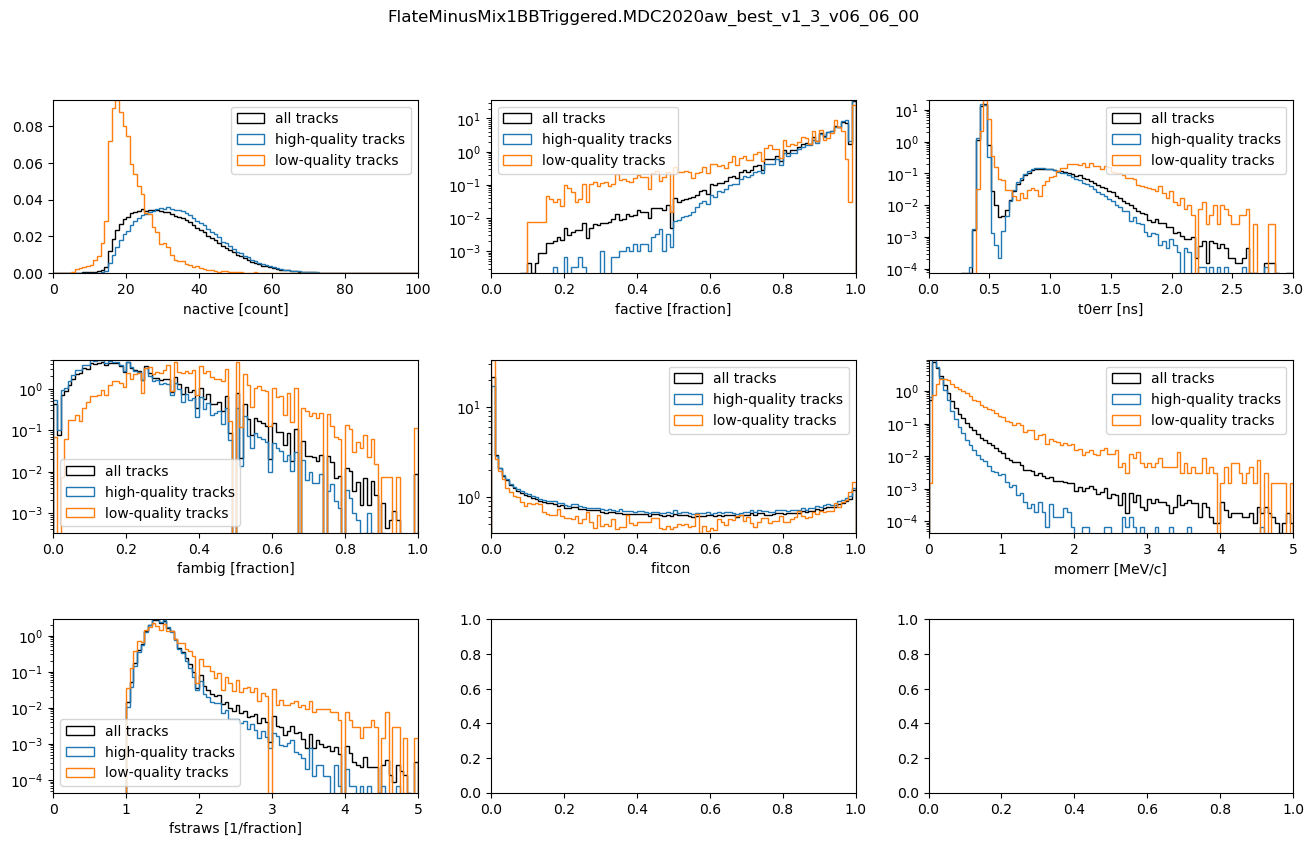

In [15]:
training_dataset = datasets[0]
fig, ax = plot_features(training_dataset)

## Prep for Trainings

First, we need to balance the inputs since we have fewer low-quality tracks to train on

In [16]:
# In this cell x_ variables are features, and y_ are the classes
min_len = min(len(training_dataset.features[training_dataset.high_qual]), len(training_dataset.features[training_dataset.low_qual]))

x_high_qual_dataset = training_dataset.features[training_dataset.high_qual][:min_len]
x_low_qual_dataset = training_dataset.features[training_dataset.low_qual][:min_len]

x_balanced_input = np.concatenate((x_high_qual_dataset, x_low_qual_dataset))
# set 1 to be high quality, and 0 to be low quality
y_balanced_input = np.concatenate((np.ones(x_high_qual_dataset.shape[0]), np.zeros(x_low_qual_dataset.shape[0])))

# split the dataset into train and test samples
x_train, x_test, y_train, y_test = train_test_split(x_balanced_input, y_balanced_input, test_size=0.5, random_state=42)
print("N train = "+str(len(x_train)) + ", N test = "+str(len(x_test)))
print("Validation dataset will be "+validation_dataset.dataset)

N train = 13449, N test = 13449
Validation dataset will be nts.mu2e.CeEndpointMix1BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root


## Train the Models!

Now we will train each model

In [17]:
for model in models_to_train:
    print(f"Training {model.name}...")
    model.fit_func(x_train, y_train, x_test, y_test)
print("Done!")

Training LDA1...
Training QDA1...
Training ANN1...
Done!


## Run the Models
Now we will run the models over all datasets (training, validation, and mock). Note that we now get predictions in the training dataset for data that we did not train on (either because the track was neither high quality or low quality, or because it was removed when we balanced the dataset)

In [18]:
# Calculate all predictions in both training and validation datasets
for dataset in datasets:
    for trained_model in models_to_train:
        print(f"Running {trained_model.name} model on {dataset.name} dataset...")
        predictions = trained_model.predict_func(dataset.features)
        dataset.add_predictions(trained_model.name, predictions)
        

Running LDA1 model on training dataset...
Running QDA1 model on training dataset...
Running ANN1 model on training dataset...
14147/14147 [==============================] - 9s 636us/step
Running LDA1 model on validation dataset...
Running QDA1 model on validation dataset...
Running ANN1 model on validation dataset...
38067/38067 [==============================] - 24s 623us/step
Running LDA1 model on mock dataset...
Running QDA1 model on mock dataset...
Running ANN1 model on mock dataset...
10697/10697 [==============================] - 7s 649us/step


## Define the TrkQual Cuts
Now we will look at the ROC curve of the training dataset for each model. We can define the TrkQual cut values that gives a 99% low-quality track rejection for each model

Generating ROC curves for training dataset...
An LDA1 trkqual cut of 0.9134 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 38.0%
An QDA1 trkqual cut of 0.9999 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 31.4%
An ANN1 trkqual cut of 0.9484 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 48.3%


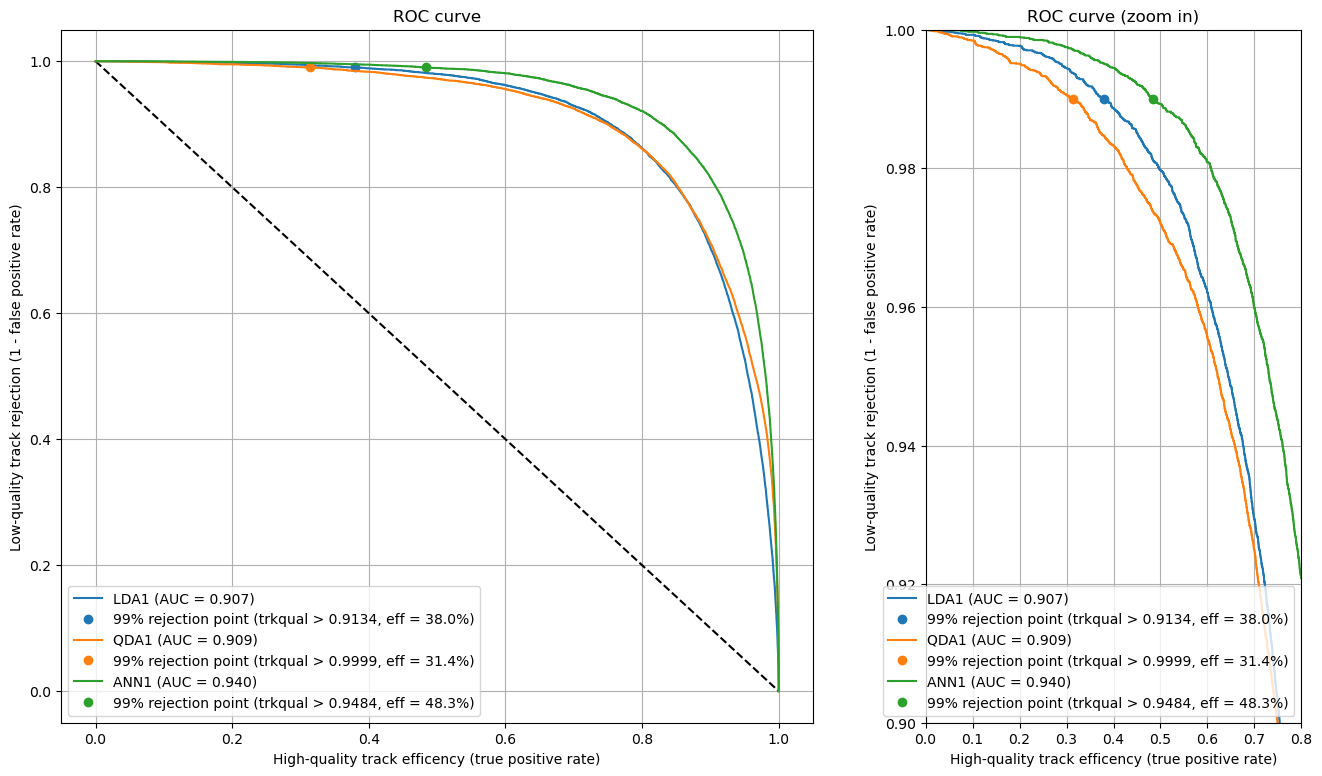

In [19]:
# For the ROC curve, we only have true labels ("high quality" and "low quality") for tracks with those definitions (i.e. some are neither)
# so we need to just extract the well-defined tracks for this
fig, axs = plt.subplots(1,2, figsize=(16,9), width_ratios=[2,1])
axs[0].plot([0, 1], [1, 0], 'k--') # plot the straight line
for dataset in [training_dataset]:
    print(f"Generating ROC curves for {dataset.name} dataset...")
    
    well_defined_labels = np.concatenate((np.ones(dataset.features[dataset.high_qual].shape[0]), np.zeros(dataset.features[dataset.low_qual].shape[0])))
    well_defined_features = np.concatenate((dataset.features[dataset.high_qual], dataset.features[dataset.low_qual]))

    trkqual_cuts=[]
    for trained_model in models_to_train:
        well_defined_predictions = np.concatenate((dataset.predictions[trained_model.name][dataset.high_qual],
                                                   dataset.predictions[trained_model.name][dataset.low_qual]))
        fpr, tpr, thresholds = roc_curve(well_defined_labels, well_defined_predictions, pos_label=1)    
        auc_result = auc(fpr, tpr)
        trained_model.add_roc_curve(fpr, tpr, thresholds)

        cut_val_index=0
        for i_point in range(0, len(fpr)):
            if 1-fpr[i_point]<0.99:
                cut_val_index=i_point-1
                break
        
        trkqual_cut=thresholds[cut_val_index]#(round(thresholds[cut_val_index], 2))

    #axs.hist(prediction, bins=100, label=trained_model.name, histtype='step')
    #axs.axvline(x=trkqual_cut, linestyle='--', color=axs.patches[-1].get_edgecolor())
    
        trained_model.add_trkqual_cut(trkqual_cut)
        bkg_rej = 1-fpr[cut_val_index]
        sig_eff = tpr[cut_val_index]
        print("An "+trained_model.name+" trkqual cut of "+str(round(trkqual_cut,4))
              +" has a low-quality track rejection of "+str(round(bkg_rej*100,1))
              +"% with a high-quality track efficiency of "+str(round(sig_eff*100,1))+"%")


        for ax in axs:
            ax.plot(tpr, 1-fpr, label=trained_model.name+' (AUC = {:.3f})'.format(auc_result))
            ax.plot(tpr[cut_val_index], 1-fpr[cut_val_index], 'o', color=ax.lines[-1].get_color(),
                     label='99% rejection point (trkqual > '+str(round(trkqual_cut,4))+', eff = '+str(round(sig_eff*100,1))+'%)')

#axs.legend()
#axs.grid(True)

for ax in axs:
    ax.set_xlabel('High-quality track efficency (true positive rate)')
    ax.set_ylabel('Low-quality track rejection (1 - false positive rate)')
    ax.set_title('ROC curve')
    ax.legend(loc='best')
    ax.grid(True)
axs[1].set_title('ROC curve (zoom in)')
axs[1].set_ylim(0.9, 1.0)
axs[1].set_xlim(0, 0.8)
plt.show()

## Compare Models
We will look at:
* the momentum resolution with the 99% background rejection cut for the training, validation, and mock datasets, and
* the trkqual cut efficiency as a function of momentum

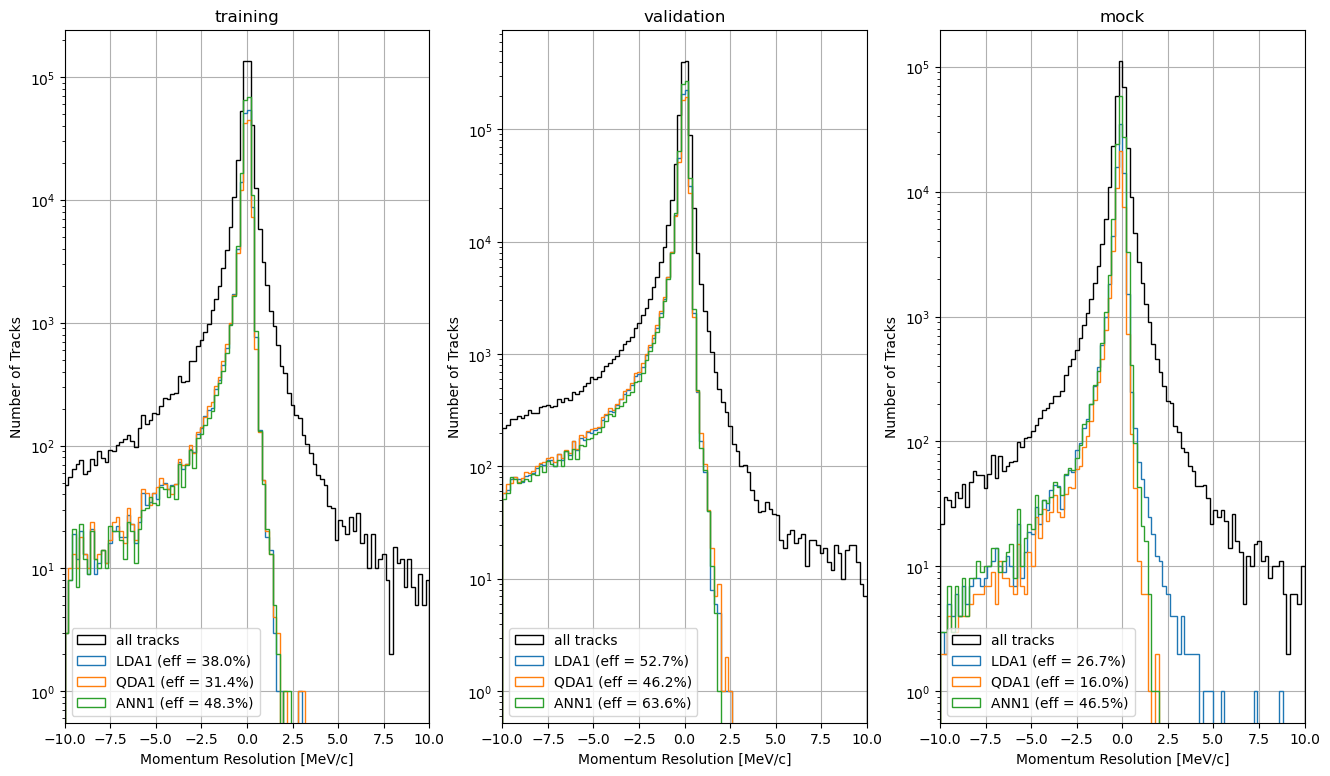

In [20]:
fig, axs = plt.subplots(1,3, figsize=(16,9))

for dataset,ax in zip(datasets, axs.ravel()):
    _, _, _, = ax.hist(dataset.mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
    for trained_model in models_to_train:
        n_high_qual_all = len(dataset.mom_res[dataset.high_qual])
        n_high_qual_select = len(dataset.mom_res[(dataset.predictions[trained_model.name]>=trained_model.trkqual_cut) & (dataset.high_qual)])
        eff = n_high_qual_select / n_high_qual_all
        _, _, _, = ax.hist(dataset.mom_res[dataset.predictions[trained_model.name]>=trained_model.trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', 
                            label=trained_model.name + " (eff = " + str(round(eff*100,1)) + "%)")
    ax.legend()
    ax.margins(x=0)
    ax.grid(True)
    ax.set_title(dataset.name)
    ax.set_xlabel("Momentum Resolution [MeV/c]")
    ax.set_ylabel("Number of Tracks")

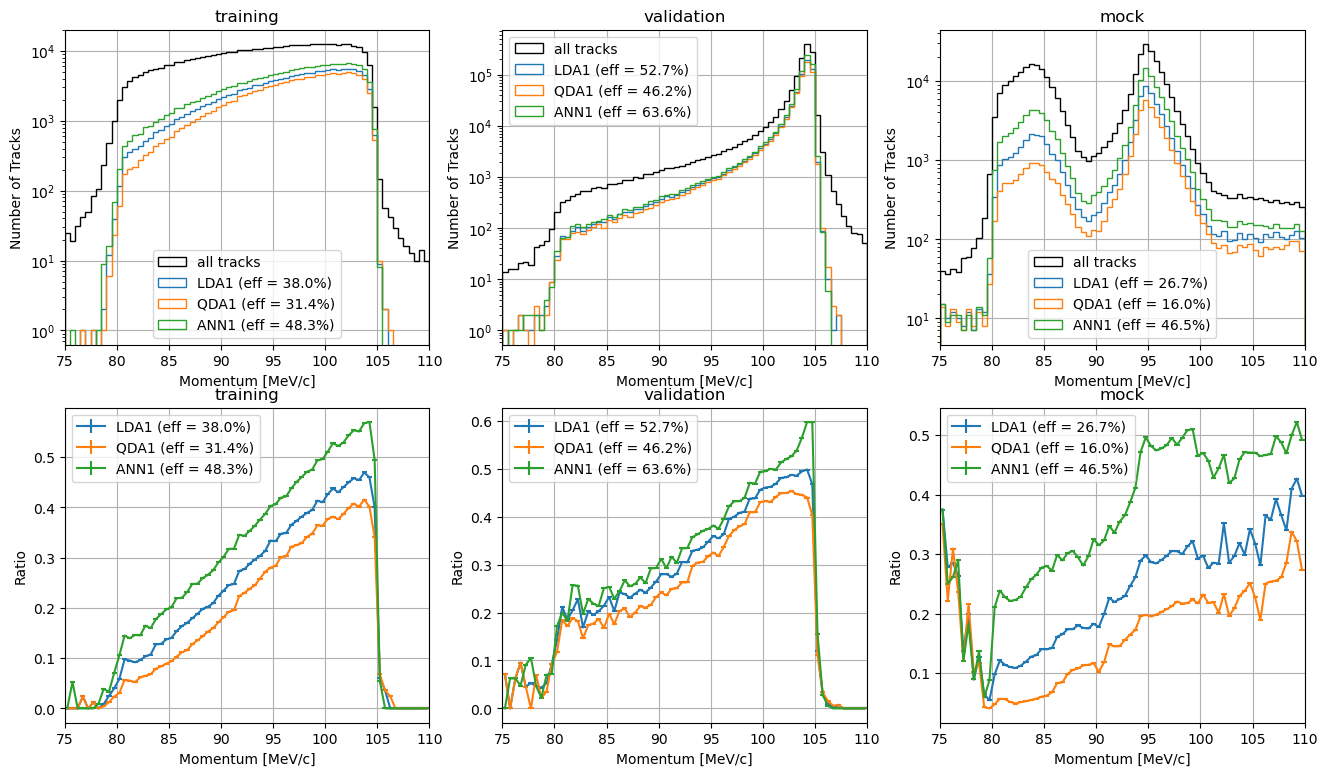

In [21]:
fig, axs = plt.subplots(2,3, figsize=(16,9))

n_reco_mom_bins=70
min_reco_mom=75
max_reco_mom=110

#n_reco_mom_bins = 10
#min_reco_mom = 85
#max_reco_mom = 95

for i,dataset in enumerate(datasets):
    all_counts, _, _, = axs[0][i].hist(dataset.reco_mom, bins=n_reco_mom_bins, range=(min_reco_mom,max_reco_mom), log=True, histtype='step', color='black', label='all tracks')
    for trained_model in models_to_train: #,name,cut,prediction in zip(models, model_names, , dataset.predictions):
        #print(name, prediction, cut)
        n_high_qual_all = len(dataset.mom_res[dataset.high_qual])
        n_high_qual_select = len(dataset.mom_res[(dataset.predictions[trained_model.name]>=trained_model.trkqual_cut) & (dataset.high_qual)])
        eff = n_high_qual_select / n_high_qual_all
        eff_err =  ((n_high_qual_select + 1)*(n_high_qual_select + 2)) / ((n_high_qual_all + 2)*(n_high_qual_all + 3)) - ( (n_high_qual_select + 1)**2 / (n_high_qual_all + 2)**2 )
        cut_counts, bins, _, = axs[0][i].hist(dataset.reco_mom[(dataset.predictions[trained_model.name]>=trained_model.trkqual_cut)], bins=n_reco_mom_bins, range=(min_reco_mom,max_reco_mom), log=True, histtype='step', 
                                            label=trained_model.name + " (eff = " + str(round(eff*100,1)) + "%)")
        ratio = np.divide(cut_counts, [float(x) for x in all_counts], out=np.zeros_like(cut_counts, dtype=float), where=all_counts!=0)
        _ = axs[1][i].errorbar((bins[:-1] + bins[1:]) / 2, ratio, xerr=(bins[1]-bins[0])/2, yerr=eff_err,
                                            label=trained_model.name + " (eff = " + str(round(eff*100,1)) + "%)")
    axs[0][i].legend()
    axs[0][i].margins(x=0)
    axs[0][i].grid(True)
    axs[0][i].set_title(dataset.name)
    axs[0][i].set_xlabel("Momentum [MeV/c]")
    axs[0][i].set_ylabel("Number of Tracks")

    axs[1][i].legend()
    axs[1][i].margins(x=0)
    axs[1][i].grid(True)
    axs[1][i].set_title(dataset.name)
    axs[1][i].set_xlabel("Momentum [MeV/c]")
    axs[1][i].set_ylabel("Ratio")

## Save the models
Now we save the model

In [22]:
for model in models_to_train:
    print(f"Saving model {model.name}...")
    model.save_func()
print("Done!")

Saving model LDA1...
LDA1 does not have an implemented save function
Saving model QDA1...
QDA1 does not have an implemented save function
Saving model ANN1...
Done!


2025-09-24 11:54:31.083512: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-09-24 11:54:31.083627: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-09-24 11:54:31.108908: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-09-24 11:54:31.109023: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


## Save some bookkeeping information for future reference

In [23]:
# Write out all histograms and plots to a ROOT file for future reference

# axis ranges for features
x_mins=[0, 0, 0, 0, 0, 0, 0]
x_maxs=[100, 1, 3, 1, 1, 5, 5]

for model in models_to_train:
    outfilename = f"TrkQual_{model.name}_v{model.training_version}_plots.root"
    outfile = uproot.recreate(outfilename)
    print(f"Saving {outfilename}...")
    for dataset in datasets:
        # Momentum resolution plots
        mom_res_hist_all = np.histogram(dataset.mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
        outfile[f"all_mom_res_{dataset.name}"] = mom_res_hist_all
        mom_res_hist_high_qual = np.histogram(dataset.mom_res[dataset.high_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
        outfile[f"high_qual_mom_{dataset.name}"] = mom_res_hist_high_qual
        mom_res_hist_low_qual = np.histogram(dataset.mom_res[dataset.low_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
        outfile[f"low_qual_mom_res_{dataset.name}"] = mom_res_hist_low_qual
        mom_res_hist_pass = np.histogram(dataset.mom_res[(dataset.predictions[model.name]>=model.trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
        outfile[f"pass_mom_res_{dataset.name}"] = mom_res_hist_pass
        mom_res_hist_fail = np.histogram(dataset.mom_res[(dataset.predictions[model.name]<model.trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
        outfile[f"fail_mom_res_{dataset.name}"] = mom_res_hist_fail

        prefixes = ["all", "high_qual", "low_qual", "pass", "fail"]
        cuts = [(), (dataset.high_qual), (dataset.low_qual), (dataset.predictions[model.name]>=model.trkqual_cut), (dataset.predictions[model.name]<model.trkqual_cut)]
        # Feature histograms
        for prefix,cut in zip(prefixes, cuts):
            for i_feature,feature_name in enumerate(feature_names):
                feature = dataset.features[:,i_feature]
                feature_all = np.histogram(feature[cut], bins=100, range=(x_mins[i_feature],x_maxs[i_feature]))
                outfile[f"{prefix}_feature{i_feature}_{feature_name}_{dataset.name}"] = feature_all
                feature_norm_all = np.histogram(feature[cut], bins=100, range=(x_mins[i_feature],x_maxs[i_feature]), density=True)
                outfile[f"{prefix}_feature{i_feature}_{feature_name}_{dataset.name}_norm"] = feature_norm_all


        df = pd.DataFrame({"tpr" : model.tpr, "fpr" : model.fpr, "thresh" : model.thresholds})
        outfile["roc_curve"] = df

#outfile["corr_matrix"] = H,xedges,yedges

print("Done!")

Saving TrkQual_LDA1_v1_plots.root...
Saving TrkQual_QDA1_v1_plots.root...
Saving TrkQual_ANN1_v2_plots.root...
Done!


## Graveyard
This section contains old plots that could be remade in future

In [24]:
# Create a correlation matrix of the features
qualities = [ high_qual, low_qual ]
qual_labels = ["high", "low"]

xs = np.linspace(0,n_features-1,n_features)
ys = xs
x_corrs=[]
y_corrs=[]
corrs=[]#np.ndarray((n_input_vars,n_input_vars))
for qual_label,quality in zip(qual_labels,qualities):
    for i_x,x in enumerate(xs):
        x_i = input_dataset[:,i_x][quality]
        mean_x = np.mean(x_i)
        for i_y,y in enumerate(ys):
            if qual_label=="high":
                if (y<x):
                    continue
            elif qual_label=="low":
                if (y>=x):
                    continue
            y_i = input_dataset[:,i_y][quality]
            mean_y = np.mean(y_i)
            corr =  ( np.sum((x_i-mean_x)*(y_i - mean_y)) ) / ((np.sqrt(np.sum((x_i-mean_x)**2)))*(np.sqrt(np.sum((y_i-mean_y)**2))))
            x_corrs.append(x+0.5)
            y_corrs.append(y+0.5)
            corrs.append(corr)

#print(x_corrs)
#print(corrs)
H, xedges, yedges = np.histogram2d(x_corrs, y_corrs, bins=np.linspace(0,n_input_vars,n_input_vars+1), weights=corrs)
X, Y = np.meshgrid(xedges, yedges)
heatmap = plt.pcolormesh(Y, X, H, cmap='coolwarm')
cbar = plt.colorbar(heatmap)
plt.clim(-1,1)
_ = plt.xticks(xs+0.5, input_var_names)
_ = plt.yticks(ys+0.5, input_var_names)
cbar.ax.set_ylabel("Pearson correlation coefficient")
#print(yedges[:-1])
for x,y,corr in zip(x_corrs,y_corrs,corrs):
    if (abs(corr)>0.0):
        plt.text(x, y, '%.2f' % corr,
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.text(0.5, 7, "high-quality tracks", fontsize='large', fontweight='bold')#, horizontalalignment='center')#, rotation=45)
plt.text(7, 0.5, "low-quality tracks", fontsize='large', fontweight='bold', rotation=-90)#, verticalalignment='center', rotation=-90)

NameError: name 'high_qual' is not defined